In [1]:
import numpy as np
import math
import scipy.stats as stats

import ROOT as R

from matplotlib import pyplot as plt
from matplotlib import animation

Welcome to JupyROOT 6.18/04


In [2]:
# parameters of the simulation                                                                                                                                  
N = 10000        # number of inhabitants                                                                                                                           
dt = 0.1       # time step (a.u.)
temperature = 2 # mean temperature (a.u) 
size = 300      # size of the town (occupancy = N/size**2)                                                                                                       
frames = int(300/dt)  # duration of the simulation                                                                                                                     
recoT = 10    # mean recovery time gaus(recoT,0.5*recoT)        
P = 0.8      # probability to infect other people at each encounter
deadP = 0.02 # probability to die when infected (die time set extracted from lognormal(2,6))
initialInfected = 0.02 #initial fraction of infected

In [3]:
R.gROOT.ProcessLine(".L epidemics.C+")

0

In [4]:
t={}
temperatures = [0.1,0.5,1,1.5,2.,2.5,3,4]

for t0 in temperatures:
    t[t0] = R.Town("COVIDYork",N,initialInfected,t0,size,recoT,P,deadP)
    print('======> ' + t[t0]._name + ' temperature {:.1f} infected {:d}'.format(t0,t[t0].nIll()))
#p = t.population()
#size = t.size()

======> COVIDYork temperature 0.1 infected 200
======> COVIDYork temperature 0.5 infected 205
======> COVIDYork temperature 1.0 infected 212
======> COVIDYork temperature 1.5 infected 187
======> COVIDYork temperature 2.0 infected 185
======> COVIDYork temperature 2.5 infected 234
======> COVIDYork temperature 3.0 infected 220
======> COVIDYork temperature 4.0 infected 203


In [5]:
import time

times={}
ills={}
totalInfected={}
totalDeaths={}
totalMeets={}
r={}

for t0 in temperatures:
    times[t0]=[]
    ills[t0]=[]
    totalInfected[t0] = []
    totalDeaths[t0] = []
    totalMeets[t0] = []
    r[t0] = []

    start = time.time()
    for i in range(0,frames):
        t[t0].step(dt)
        times[t0].append((i+1)*dt)
        ills[t0].append(float(t[t0].nIll())/t[t0]._population.size())
        totalInfected[t0].append(1-float(t[t0].nSusceptible())/t[t0]._population.size())
        totalDeaths[t0].append(1-float(t[t0]._population.size())/N)
        totalMeets[t0].append(t[t0].nMeet()/(N*(i+1)*dt)/10.)
        r[t0].append(t[t0].nTransmissionPerInfected())
    #    print('t: {:5d} p: {:6d} p/N: {:3.0f} % i/p: {:5.2f} %'.
    #          format(i, p.size(), p.size()/float(N)*100, float(ills[-1])/p.size()*100))
    end = time.time()
    print("Elapsed time {:.2f}s Total infected {:.2f}".format(end - start,totalInfected[t0][-1]))
tem

Elapsed time 1.89s Total infected 0.05
Elapsed time 1.96s Total infected 0.33
Elapsed time 2.08s Total infected 0.67
Elapsed time 2.14s Total infected 0.78
Elapsed time 2.23s Total infected 0.86
Elapsed time 2.15s Total infected 0.91
Elapsed time 2.01s Total infected 0.92
Elapsed time 2.05s Total infected 0.95


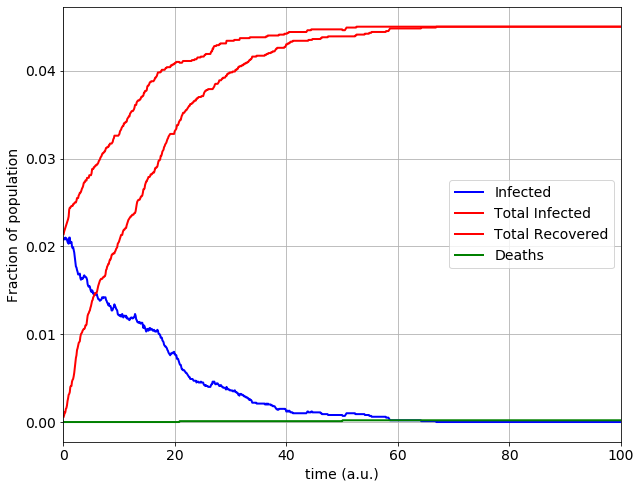

In [17]:
temp=0.1
fig = plt.figure(figsize=(10, 8))
plt.rc('font', size=14)
plt.plot(times[temp], ills[temp], 'b-', lw=2,label='Infected')
plt.plot(times[temp], totalInfected[temp], 'r-',lw=2,label='Total Infected')
plt.plot(times[temp], np.asarray(totalInfected[temp])-np.asarray(ills[temp]), 'r-',lw=2,label='Total Recovered')
plt.plot(times[temp], totalDeaths[temp], 'g-',lw=2,label='Deaths')
plt.xlim(0,100)

#plt.yscale('log')
plt.grid(True)
plt.legend()
plt.xlabel("time (a.u.)")
plt.ylabel("Fraction of population")
plt.show()

#export to csv
import pandas as pd
for t0 in temperatures:
    dataDict={}
    for i in range(len(times[t0])):
        dataDict[times[t0][i]]=[1-totalInfected[t0][i],ills[t0][i],totalDeaths[t0][i]]

    data=pd.DataFrame.from_dict(dataDict, orient='index')
    csv_file = "epidemics2DGasSim_{:d}_{:.1f}.csv".format(size,t0)
    data.to_csv(csv_file,index=True,header=False)

#import csv
#csv_columns = ['time','infected','susceptible','death']
#
#try:
#    with open(csv_file, 'w') as csvfile:
#        w = csv.DictWriter(csvfile, fieldnames=csv_columns)
#        w.writeheader()
#        w.writerow(dataDict)
#except IOError:
#    print("I/O error")

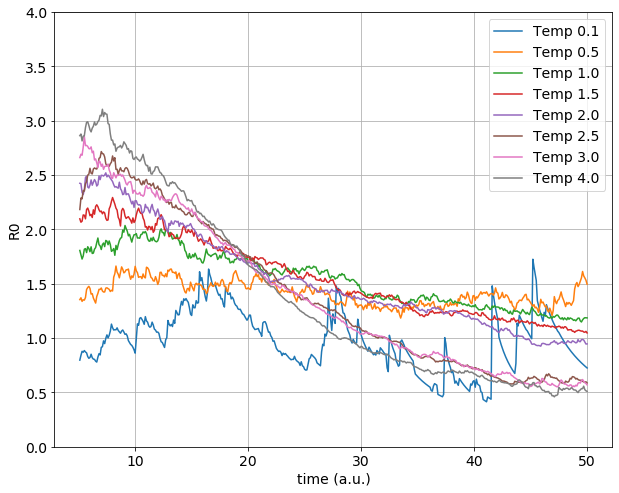

In [7]:
plt.figure(figsize=(10, 8))
r0mean=[]
r0rms=[]
for itemp,t0 in enumerate(temperatures):
    plt.plot(times[t0][int((recoT/dt)*0.5):int(recoT/dt*5)],r[t0][int((recoT/dt)*0.5):int(recoT/dt*5)],label="Temp {:.1f}".format(t0))
    #(ar, br, cr) = np.polyfit(times[t0][int((recoT/dt)*0.5):int(recoT/dt*2.)], r[t0][int((recoT/dt)*1.):int(recoT/dt*2.)], 2)
    r0mean.append(np.average(np.asarray(r[t0][int((recoT/dt)*0.8):int(recoT/dt*1.2)])))
    r0rms.append(np.std(np.asarray(r[t0][int((recoT/dt)*0.8):int(recoT/dt*1.2)])))
    #print(ar, br, cr)
#print(r0mean)
plt.legend()
plt.grid(True)
plt.ylim(0.,4.)
plt.xlabel("time (a.u.)")
plt.ylabel("R0")
plt.show()

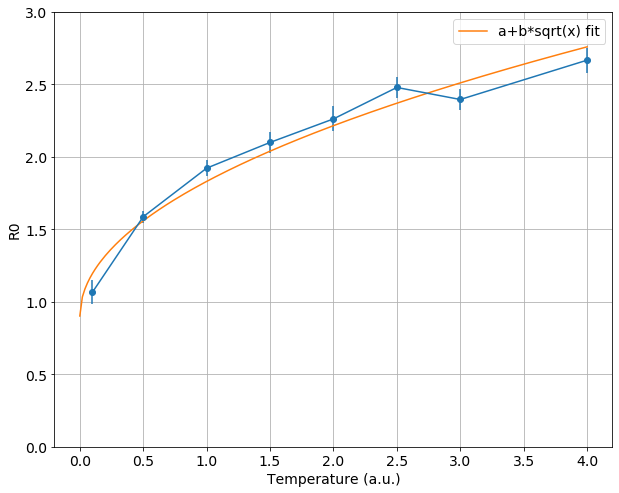

In [8]:
n = 200
x = np.linspace(0,max(temperatures),n)

def sqrt_model(x,a,b):
    return b+a*np.sqrt(x)

from scipy.optimize import curve_fit

fitS = curve_fit(sqrt_model,temperatures,r0mean,p0=[1.7,0.5])
#(ar, br, cr) = np.polyfit(temperatures, r0mean, 2)
#xr = np.polyval([ar, br, cr], x)


plt.figure(figsize=(10, 8))
plt.errorbar(temperatures,r0mean,xerr=0.,yerr=r0rms,fmt='o-')
plt.plot(x,sqrt_model(x,fitS[0][0],fitS[0][1]),label='a+b*sqrt(x) fit')

plt.legend()
plt.grid(True)
plt.ylim(0.,3.)
plt.xlabel("Temperature (a.u.)")
plt.ylabel("R0")
plt.show()

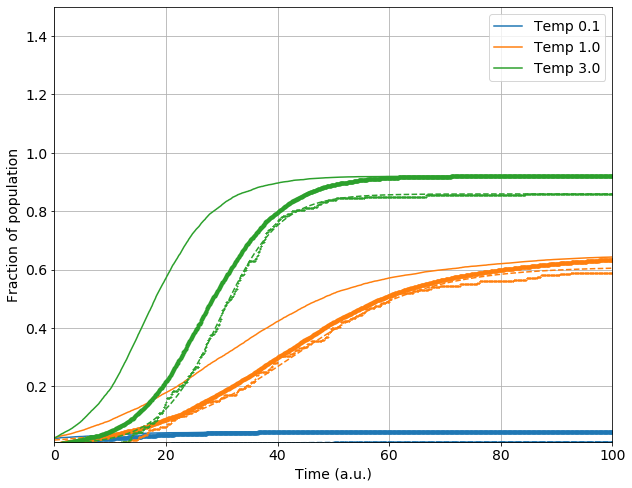

In [9]:


def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

x = np.linspace(0, 300, int(300/dt))
plt.figure(figsize=(10, 8))
aFit=[]
aErr=[]
bestFit={}
errors={}
for t0 in temperatures:
    fit = curve_fit(logistic_model,times[t0],totalDeaths[t0],p0=[2,20,0.7])

    bestFit[t0] = [fit[0][i] for i in range(3)]
    errors[t0] = [np.sqrt(fit[1][i][i]) for i in range(3)]
    aFit.append(fit[0][0])
    aErr.append(np.sqrt(fit[1][0][0]))
    #print("temperature {:.1f}".format(t0))
    #print(bestFit)
    #print(errors)
for t0 in [0.1,1,3]:
    p0=plt.plot(times[t0],[float(i)/deadP for i in totalDeaths[t0]],'+',markersize=2)
    plt.plot(times[t0],totalInfected[t0],'-',color=p0[0].get_color(),label="Temp {:.1f}".format(t0))
    #plt.plot(times[t0],ills[t0],color=p0[0].get_color())
    plt.plot(times[t0],[float(totalInfected[t0][i]-ills[t0][i]) for i in range(len(totalInfected[t0]))],'.',color=p0[0].get_color())
    #plt.plot(times[t0][100:],[float(totalInfected[t0][i]-ills[t0][i])/totalDeaths[t0][i]*deadP/(1-deadP) for i in range(100,len(totalInfected[t0]))],'o',color=p0[0].get_color())
    plt.plot(x, logistic_model(x,bestFit[t0][0],bestFit[t0][1],bestFit[t0][2])/deadP,"--",color=p0[0].get_color())

plt.legend()
plt.grid(True)
plt.xlim(0,100)
plt.ylim(0.01,1.5)
plt.xlabel("Time (a.u.)")
plt.ylabel("Fraction of population")
#plt.yscale('log')
plt.show()

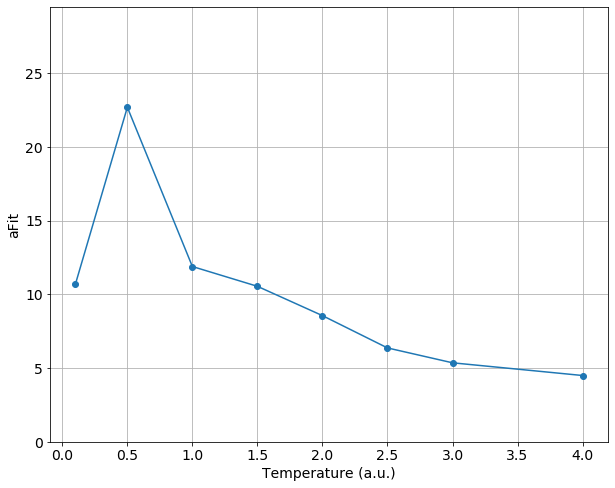

In [10]:
plt.figure(figsize=(10, 8))
plt.errorbar(temperatures,aFit,xerr=0.,yerr=aErr,fmt='o-')
#plt.plot(x,xr,label='polynomial fit')

#plt.legend()
plt.grid(True)
plt.ylim(0.,max(aFit)*1.3)
plt.xlabel("Temperature (a.u.)")
plt.ylabel("aFit")
plt.show()